# FashionMNIST Challenge 之 深度殘差神經網絡

## 一、算法原理
        咳咳,先不說算法原理,先來介紹一下這個算法深度殘差網絡是什麼.深度殘差網絡是由4個華人在2015年提出的深度卷積網絡,一經出世,便在ImageNet大賽中一舉拿下圖像分類、檢測、定位的三項世界冠軍.
        接下來開始以我微薄的認知來說一說這個模型,如有錯誤,歡迎批評指正.
        我們都知道增加網絡的寬度和深度都可以很好的提高網絡的性能,一般來說,深的網絡比淺的網絡效果要好,或者說深的網絡效果至少可以達到淺的網絡效果,原因很簡單,我們可以嘗試把淺的模型完全遷移到深的模型前n層,而深的模型的後幾層則全部由等價影射組成,這樣就可以達到和淺的網絡一樣的效果.那假設後面的那幾層不是等價影射,而是繼續計算呢?這個例子就好比VGG,該網絡就是在AlexNet的基礎上通過增加網絡深度而大大的提高了整個網絡的性能.
        我们都知道增加网络的宽度和深度可以很好的提高网络的性能，深的网络一般都比浅的的网络效果好，比如说一个深的网络A和一个浅的网络B，那A的性能至少都能跟B一样，为什么呢？因为就算我们把A的网络参数全部迁移到B的前面几层，而B后面的层只是做一个等价的映射，就达到了A网络的一样的效果。一个比较好的例子就是VGG，该网络就是在AlexNex的基础上通过增加网络深度大幅度提高了网络性能。 
        但是事實卻並非如此,就想一個限度,超過了限度,反而結果會變得更加糟糕,這種情況被稱為degradation.
<img src="http://img.blog.csdn.net/20161028170240163"  alt="http://blog.csdn.net/scety/article/details/52957991">
    
        這是由於性能退化造成的,於是殘差網絡便橫空出世,很好的解決了這個問題.ResNet採用了跳躍結構來作為網路的基本結構。至於為什麼要使用這種結構,使用這個結構有明顯的改善效果,我認為，原本我們要優化的目標是H(x)=F(x)+x（x就是該結構的輸入）,但是通過這種結構以後就把優化的目標由H(x)轉化為H(x)-x。我之前提到，深網路在淺網路的基礎上只要上面幾層做一個等價映射就可以達到淺網路同樣的效果，但是終究不行的原因，或許是因為我們的算法很難將其訓練到那個程度，也就是沒辦法將上面幾層訓練到一個等價映射， 以至於深網路最後達到了一個更差的效果。 那麼這時，我們把訓練目標轉變，由原來的H(x)轉為H(x)-x，因為這時候就不是把上面幾層訓練到一個等價映射了，而是將其逼近與0，這樣訓練的難度比訓練到一個等價映射應該下降了很多。也就是說，在一個網路中（假設有5層），如果前面四層已經達到一個最優的函數，那第五層就是沒有必要的了，這時我們通過這種跳躍結構，我們的優化目標就從一個等價映射變為逼近0了，逼近其他任何函數都會造成網路退化。 通過這種方式就可以解決網路太深難訓練的問題。(這段稍為抄了一下)
        至於下面算法不使用ResNet18和ResNet50,而選擇了自己造一個殘差網絡,原因是原本的resent輸入層過大,且為3通道,在此使用計算量過大而且我的計算機根本跑不動啊!!!😭😭所以早了一個輕量級的殘差網絡,效果最高可以達到90.5% .


## 二、算法實現

In [1]:
import keras
import tensorflow as tf
from PIL import Image
from keras.models import model_from_json, load_model
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Input
from keras.layers import AveragePooling2D, Flatten, GlobalMaxPooling2D
from keras import layers
from keras.models import Model

def conv_block(input_tensor, bn_axis, filters, phase, name, strides=(1, 1)):
    """
    Conv2D 塊，雙路雙卷積計算
    :param input_tensor:(tensor) 輸入張量
    :param filters:(tuple) 卷積核打包
    :param strides:(int) 卷積步長
    :param BN_axis:(int) 規範化卷積軸
    :return: model
    """
    filters1, filters2, filters3 = filters  # 解包卷積核數量
    Conv_base_name = 'Conv_' + name + '_' + str(phase) + '_phase_'
    BN_base_name = 'BN_' + name + '_' + str(phase) + '_phase_'
    x = Conv2D(
        filters=filters1, kernel_size=(1, 1), strides=strides, name=Conv_base_name + '2a'
    )(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=BN_base_name + '2a')(x)
    x = Activation(activation='relu')(x)

    x = Conv2D(
        filters=filters2, kernel_size=(1, 1), strides=strides, name=Conv_base_name + '2b'
    )(x)
    x = BatchNormalization(axis=bn_axis, name=BN_base_name + '2b')(x)
    x = Activation(activation='relu')(x)

    x = Conv2D(
        filters=filters3, kernel_size=(1, 1), strides=strides, name=Conv_base_name + '2c'
    )(x)
    x = BatchNormalization(axis=bn_axis, name=BN_base_name + '2c')(x)
    x = Activation(activation='relu')(x)

    y = Conv2D(filters3, (1, 1), strides=strides, name=Conv_base_name + '1a')(input_tensor)
    y = BatchNormalization(axis=bn_axis, name=BN_base_name + '1b')(y)

    x = layers.add([x, y])
    a = Activation('relu')(x)

    return a


def identity_block(input_tensor, bn_axis, filters, phase, name, strides=(1, 1)):
    """
    Conv2D 塊，雙路單卷積計算
    :param input_tensor:(tensor) 輸入張量
    :param filters:(tuple) 卷積核打包
    :param strides:(int) 卷積步長
    :param BN_axis:(int) 規範化卷積軸
    :return: model
    """
    filters1, filters2, filters3 = filters  # 解包卷積核數量
    Conv_base_name = 'Conv_' + name + '_' + str(phase) + '_phase_'
    BN_base_name = 'BN_' + name + '_' + str(phase) + '_phase_'
    x = Conv2D(
        filters=filters1, kernel_size=(1, 1), strides=strides, name=Conv_base_name + '2a'
    )(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=BN_base_name + '2a')(x)
    x = Activation(activation='relu')(x)

    x = Conv2D(
        filters=filters2, kernel_size=(1, 1), strides=strides, name=Conv_base_name + '2b'
    )(x)
    x = BatchNormalization(axis=bn_axis, name=BN_base_name + '2b')(x)
    x = Activation(activation='relu')(x)

    x = Conv2D(
        filters=filters3, kernel_size=(1, 1), strides=strides, name=Conv_base_name + '2c'
    )(x)
    x = BatchNormalization(axis=bn_axis, name=BN_base_name + '2c')(x)
    x = Activation(activation='relu')(x)

    x = layers.add([x, input_tensor])
    a = Activation('relu')(x)

    return a


def my_resnet():
    inputs = Input(shape=(1, 28, 28))

    x = Conv2D(
        filters=4, kernel_size=(3, 3), padding='same', name='Conv1', data_format='channels_first')(inputs)
    x = BatchNormalization(axis=1, name='BN_Conv1')(x)
    x = Activation('relu')(x)
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), data_format='channels_first')(x)

    x = conv_block(input_tensor=x, bn_axis=1, filters=(4, 4, 64), phase=2, name='a')
    x = identity_block(input_tensor=x, bn_axis=1, filters=(4, 4, 64), phase=2, name='b')
    x = identity_block(input_tensor=x, bn_axis=1, filters=(4, 4, 64), phase=2, name='c')
    
    # x = conv_block(input_tensor=x, bn_axis=1, filters=(8, 8, 512), phase=3, name='a')
    # x = identity_block(input_tensor=x, bn_axis=1, filters=(8, 8, 512), phase=3, name='b')
    # x = identity_block(input_tensor=x, bn_axis=1, filters=(8, 8, 512), phase=3, name='c')

    x = AveragePooling2D((2, 2), name='avg_pool')(x)
    x = Flatten()(x)
    x = Dense(10, activation='softmax', name='softmax10')(x)
    # x = GlobalMaxPooling2D()(x)

    model = Model(inputs, x, name='My_Resnet')
    return model


def create_model():
    """返回一個已創建好的 resnet model"""
    # model = keras.applications.resnet50.ResNet50(include_top=True, weights=None,
    #                                              input_tensor=None, input_shape=(224, 224, 3),
    #                                              pooling='max',
    #                                              classes=10)
    model = my_resnet()
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


Using TensorFlow backend.


In [3]:
def read_tfrecord(filename, tensor=[1, 784], num=5000):
    """
    讀取tfrecord文件數據
    :param filename: 文件名
    :param tensor: 緯度
    :param num: 讀取數據數量
    :return: images 圖片數據列表    labels(numpy) 標籤列表    maxlabels(int) 標籤所在項
    """
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'img_val': tf.FixedLenFeature(tensor, tf.float32),
                                       })
    image = tf.cast(features['img_val'], tf.float64)
    label = tf.cast(features['label'], tf.int32)
    images = []
    labels = []
    maxlabels = []
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        for i in range(num):
            example, l = sess.run([image, label])
            arr = np.array(example[0])
            arr = arr.reshape((28, 28))
            images.append([arr])
            tem = np.zeros((1, 10))
            tem[0][l] = 1.0
            labels.append(tem[0])
            maxlabels.append([l])
            del tem
        coord.request_stop()
        coord.join(threads=threads)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, maxlabels


def trun(arr):
    out_arr = []
    for img in arr:
        img = Image.fromarray(img.reshape([28, 28])).resize([224, 224])
        img = np.asarray(img)
        im = []
        for a in img:
            row = []
            for b in a:
                row.append([b, b + 0.0, b + 0.0])
            im.append(row)
            del row
        out_arr.append(im)
        del im
    return out_arr


def getdata(train=55000, test=5000):
    trimages, trlabels, _ = read_tfrecord('train.tfrecords', num=train, )
    teimages, telabels, _ = read_tfrecord('test.tfrecords', num=test, )
    # trimages = trun(trimages)
    # teimages = trun(teimages)

    return trimages, trlabels, teimages, telabels


def main(train=55000, test=5000, batch_size=128, epochs=20):
    trimages, trlabels, tsimages, tslabels = getdata(train=train, test=test)
    model = create_model()
    # from keras.utils import plot_model
    # plot_model(model, to_file='./Resnet_model.png')
    tem = model.fit(trimages, trlabels, batch_size=batch_size, epochs=epochs, )
    paint(tem.history)

    model.evaluate(tsimages, tslabels, batch_size=batch_size)
    model.save('./resnet.h5')


def paint(hist):
    import matplotlib.pyplot as plt
    %matplotlib notebook
    # fig = plt.figure(figsize=(6, 3))
    ti = []
    for i in range(len(hist['loss'])):
        ti.append(i)
    plt.plot(ti, hist['loss'], c='red')
    plt.plot(ti, hist['acc'], c='blue')
    plt.show()


def test_model(num=1000.0):
    timages, tlabels, _ = read_tfrecord('test.tfrecords', num=int(num))

    model = load_model('./resnet.h5')
    pre = model.predict(timages)
    tr = 0
    for a, b in zip(tlabels, pre):
        a = np.argmax(a)
        b = np.argmax(b)
        if a == b:
            tr += 1
    ls = tr / num
    print("正確率為：{0}".format(ls))


def train_model():
    from tensorflow.examples.tutorials.mnist import input_data
    data = input_data.read_data_sets('./data/', validation_size=5000)
    model = load_model('./resnet.h5')
    model.fit()


def test():
    from tensorflow.examples.tutorials.mnist import input_data
    data = input_data.read_data_sets('./data/', validation_size=5000)
    data = data.train.next_batch(5000)
    img = []
    label = []
    for i in data[0]:
        i = np.reshape(i, [28, 28])
        img.append(i)
    print("轉換完成")
    for i in data[1]:
        tem = np.zeros((1, 10))
        tem[0][i] = 1.0
        label.append(tem[0])
    print('轉換完成')
    model = create_model()
    model.fit(img, label, batch_size=50, epochs=5, )
    model.evaluate(img, label, batch_size=50)
    model.save('./resnet_test.h5')


Epoch 1/50
55000/55000 [==============================] - 359s 7ms/step - loss: 0.7545 - acc: 0.7467
Epoch 2/50
55000/55000 [==============================] - 365s 7ms/step - loss: 0.4089 - acc: 0.8563
Epoch 3/50
55000/55000 [==============================] - 351s 6ms/step - loss: 0.3542 - acc: 0.8741
Epoch 4/50
55000/55000 [==============================] - 356s 6ms/step - loss: 0.3236 - acc: 0.8839
Epoch 5/50
55000/55000 [==============================] - 354s 6ms/step - loss: 0.3028 - acc: 0.8913
Epoch 6/50
55000/55000 [==============================] - 657s 12ms/step - loss: 0.2883 - acc: 0.8964
Epoch 7/50
55000/55000 [==============================] - 380s 7ms/step - loss: 0.2763 - acc: 0.9017
Epoch 8/50
55000/55000 [==============================] - 380s 7ms/step - loss: 0.2632 - acc: 0.9046
Epoch 9/50
55000/55000 [==============================] - 375s 7ms/step - loss: 0.2553 - acc: 0.9081
Epoch 10/50
55000/55000 [==============================] - 383s 7ms/step - loss: 0.2471 - 


Bad key "ckend" on line 1 in
/Users/tudoudou/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


<IPython.core.display.Javascript object>


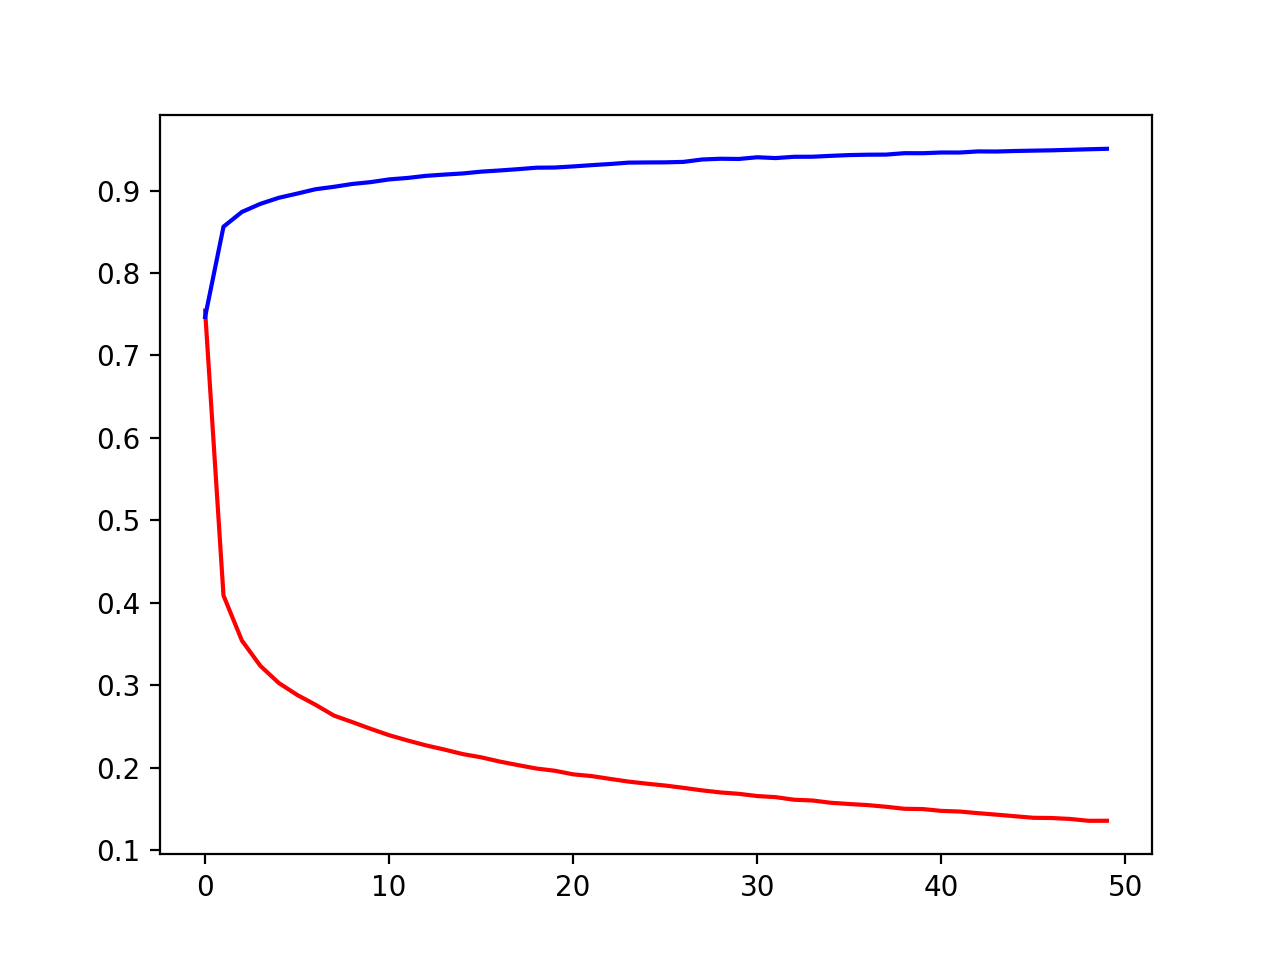

5000/5000 [==============================] - 21s 4ms/step


In [4]:
if __name__ == '__main__':
    main(epochs=50)

    # test()
    # test_model(num=5000)
    # x_train = np.random.random((2,5,5))
    # print(x_train)

In [ ]:
test_model(num=10000)

## 三、實踐總結
1. 先上個上面算法的模型圖陣陣場
<img src="./Resnet_model.png">
2. 結果就是上不去,一定不是模型的問題(畫圈圈),一定是數據集在搞鬼,一定是的


參考連結:
1. [深度残差网络（ResNet）浅析](http://blog.csdn.net/scety/article/details/52957991)
2. [為什麼ResNet和DenseNet可以這麼深](http://bangqu.com/QuxRV5.html)

#### 完成人: 曹國鴻 完成時間:2017年11月25日